In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import graphviz as gr

In [2]:
def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

In [3]:
###Q1 Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates.

In [4]:
np.random.seed(11)
n = 2000
T = np.random.binomial(1, 0.5, n)
X = np.random.normal(20,5,n)
Y = np.random.normal(1 + 1*T + 1*X, 5).astype(int)
data1 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data1.to_csv("data1.csv", index=False)

# Illustrate DGP with a DAG

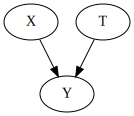

In [5]:
g = gr.Digraph()
g.edge("X", "Y")
g.edge("T", "Y")
g

In [6]:
##Monte Carlo experiment

In [7]:
##case a : You do not control for any covariates

In [8]:
class MC_Simulator_a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        X = np.random.normal(20,5,n)
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(a + b*T + 1*X, 5).astype(int)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        theta0 = b
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            [a_hat,b_hat], se = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [bias,RMSE,treatment_effect]

In [9]:
# N=100
mcSim_100 = MC_Simulator_a(2000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(2000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,-0.004822,-0.006864
RMSE,1.483197,0.446975
size,0.065500,0.052500


In [10]:
##case b : You control for all the covariates that affect the outcome

In [11]:
class MC_Simulator_b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        X = np.random.normal(20,5,n)
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(a + b*T + c*X, 5).astype(int)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
                
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        theta0 = b
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            [a_hat,b_hat,c_hat], se = self.estimate_ols_params(Y,T,X)
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, size = self.run_mc_simulation(a,b,c,n,sigma)
        return [bias,RMSE,size]

In [12]:
# N=100
mcSim_100 = MC_Simulator_b(2000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_b(2000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,-0.020132,-0.000444
RMSE,1.004361,0.323818
size,0.832500,0.850000


In [15]:
##example of real-life situation that might be consistent with the DGP

In [16]:
"""Y : sales of a product
X : price level of the produc
T : advertisement
"""

'Y : sales of a product\nX : price level of the produc\nT : advertisement\n'

In [17]:
##Simulate a DGP with a confounder (common cause)

In [18]:
np.random.seed(22)
n = 2000
# generate covariate
X = np.random.normal(1,5,n)
# generate treatment
T = np.random.binomial(1, 1/(1+X**2), n)
# generate outcome
Y = np.random.normal(1 + 1*T + 1*X, 5).astype(int)
data2 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data2.to_csv("data2.csv", index=False)

In [19]:
##Illustrate DGP with a DAG

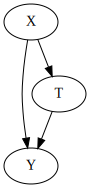

In [20]:
g = gr.Digraph()
g.edge("X", "Y")
g.edge("X", "T")
g.edge("T", "Y")
g

In [21]:
##Monte Carlo experiment

In [22]:
##case a : You fail to control for the confounder

In [23]:
class MC_Simulator_a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        X = np.random.normal(1,5,n)
        T = np.random.binomial(1, 1/(1+X**2), n)
        Y = np.random.normal(a + b*T + 1*X, 5).astype(int)
        
        return (Y,T)  

    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        theta0 = b
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            [a_hat,b_hat], se = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [bias,RMSE,treatment_effect]

In [24]:
# N=100
mcSim_100 = MC_Simulator_a(2000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(2000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,-1.124731,-1.141297
RMSE,1.777643,1.222175
size,0.066000,0.613500


In [25]:
##case b : You do control for the confounder

In [26]:
class MC_Simulator_b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        X = np.random.normal(1,5,n)
        T = np.random.binomial(1, 1/(1+X**2), n)
        Y = np.random.normal(a + b*T + c*X, 5).astype(int)
        
        return (Y,T,X) 
    
    def estimate_ols_params(self,Y,T,X):
                
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        theta0 = b
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            [a_hat,b_hat,c_hat], se = self.estimate_ols_params(Y,T,X)
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,c,n,sigma)
        return [bias,RMSE,treatment_effect]

In [27]:
# N=100
mcSim_100 = MC_Simulator_b(2000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_b(2000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,-0.100553,-0.099125
RMSE,1.170102,0.367839
size,0.856000,0.865000


In [28]:
##example of real-life situation that might be consistent with the DGP

In [29]:
"""T : advertisement.  
Y : sales of the product.
X : consumers' loyalty to the brand of the product."""

"T : advertisement.  \nY : sales of the product.\nX : consumers' loyalty to the brand of the product."

In [30]:
###Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)

In [31]:
np.random.seed(22)
n = 2000
# generate treatment
T = np.random.binomial(1, 0.5, n)
# generate outcome
Y = np.random.normal(1 + 1*T, 5).astype(int)
# generate covariate
X = np.random.normal(10+np.mean(T)*np.mean(Y),5,n)

data3 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data3.to_csv("data3.csv", index=False)

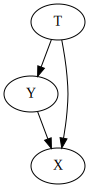

In [32]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("T", "X")
g.edge("Y", "X")
g

In [33]:
##Monte Carlo experiment

In [34]:
##case a : You control for the variable in between the path from cause to effect

In [35]:
class MC_Simulator_a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(1 + 1*T, 5).astype(int)
        X = np.random.normal(10+np.mean(T)*np.mean(Y),5,n)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
                
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        theta0 = 1
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            [a_hat,b_hat,c_hat], se = self.estimate_ols_params(Y,T,X)
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, size = self.run_mc_simulation(a,b,c,n,sigma)
        return [bias,RMSE,size]

In [36]:
# N=100
mcSim_100 = MC_Simulator_a(2000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(2000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,-0.070345,-0.072774
RMSE,0.928190,0.295445
size,0.842500,0.843000


In [37]:
##case b : You do not control for the variable in between the path from cause to effect

In [38]:
class MC_Simulator_b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(1 + 1*T, 5).astype(int)
        X = np.random.normal(10+np.mean(T)*np.mean(Y),5,n)
        
        return (Y,T)  
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        theta0 = 1
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            [a_hat,b_hat], se = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [bias,RMSE,treatment_effect]

In [39]:
# N=100
mcSim_100 = MC_Simulator_b(2000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_b(2000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,-0.088029,-0.083001
RMSE,0.932487,0.298679
size,0.047000,0.055000


In [40]:
##example of real-life situation that might be consistent with the DGP

In [41]:
"""T : advertisement 
Y : sales of the product
X : new production level the product"""

'T : advertisement \nY : sales of the product\nX : new production level the product'

In [42]:
##Q4 Simulate a DGP where the outcome variable is overrepresented at 0.

In [43]:
# simulation
np.random.seed(24)
n = 2000

T = np.random.binomial(1, 0.5, n)

X = np.random.gamma(1, 1, n)

P = np.random.normal(5 + 0.3+X, 500)
P = ((P > 800) & (P == 1)).astype(int)

Y = (np.random.normal(-2+1*P, 10).astype(int))+ 0.5*X
for i in range(len(Y)):
    if Y[i]<0:
        Y[i]=0

data4 = pd.DataFrame(dict(Y=Y,
                         P=P,
                         T=T,
                         X=X))

data4.to_csv("data4.csv", index=False)

In [44]:
##illustrate the DGP with DAG

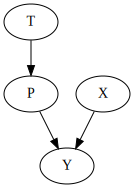

In [45]:
g = gr.Digraph()

g.edge("T", "P"), g.edge("P", "Y")
g.edge("X", "Y")

g

In [46]:
##You estimate the treatment effect parameter using the Conditional-on-Positives (COP) framework

In [13]:
class MC_Simulator_a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        T = np.random.binomial(1, 0.5, n)
        X = np.random.gamma(1, 1, n)
        P = np.random.normal(5 + 0.3+X, 500)
        P = ((P > 800) & (T == 1)).astype(int)
        Y = (np.random.normal(-2+1*P, 10).astype(int))+ 0.5*X
        for i in range(len(Y)):
            if Y[i]<0:
                Y[i]=0
        df = pd.DataFrame(dict(Y=Y,P=P,T=T,X=X))
        for i in range(len(df)):
            p = np.random.binomial(1,0.5)
            if df['Y'].loc[i]==0:
                if p==1:
                    df.drop([i],inplace = True)
        Y = np.array(df['Y'])
        T = np.array(df['T'])
        X = np.array(df['X'])
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
                
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        theta0 = -2
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            [a_hat,b_hat,c_hat], se = self.estimate_ols_params(Y,T,X)
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, size = self.run_mc_simulation(a,b,c,n,sigma)
        return [bias,RMSE,size]

In [20]:
# N=100
mcSim_100 = MC_Simulator_a(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,2.003050,2.030723
RMSE,2.387525,2.073444
size,0.703000,1.000000


In [21]:
## You estimate the treatment effect using the conventional method of comparing the outcomes of treated and untreated individuals.

In [24]:
class MC_Simulator_b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        T = np.random.binomial(1, 0.5, n)
        X = np.random.gamma(1, 1, n)
        P = np.random.normal(5 + 0.3+X, 500)
        P = ((P > 800) & (T == 1)).astype(int)
        Y = (np.random.normal(-2+1*P, 10).astype(int))+ 0.5*X
        for i in range(len(Y)):
            if Y[i]<0:
                Y[i]=0
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
                
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        theta0 = -2
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            [a_hat,b_hat,c_hat], se = self.estimate_ols_params(Y,T,X)
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size

In [25]:
# N=100
mcSim_100 = MC_Simulator_a(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,2.038617,2.022876
RMSE,2.440615,2.066470
size,0.718000,1.000000


In [26]:
##real-life example

In [27]:
"""
T:Advertise or not.  
Y:Amount of consumption.  
P:consumption possibility. 
X:income."""

'\nT:Advertise or not.  \nY:Amount of consumption.  \nP:consumption possibility. \nX:income.'